# Artificial Neural Network
## Importing module, Device setting
window에서도 사용하고 mac에서도 사용하기 때문에 device는 if문을 중첩시켜서 사용하였다.

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

device = 'cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
torch.manual_seed(777)
device

'mps'

## Dataset 준비, 시각화

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
PATH = "../../../" # FashionMNIST 데이터셋 다운 경로

training_data = datasets.FashionMNIST(
    root=PATH,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=PATH,
    train=False,
    download=True,
    transform=ToTensor()
)

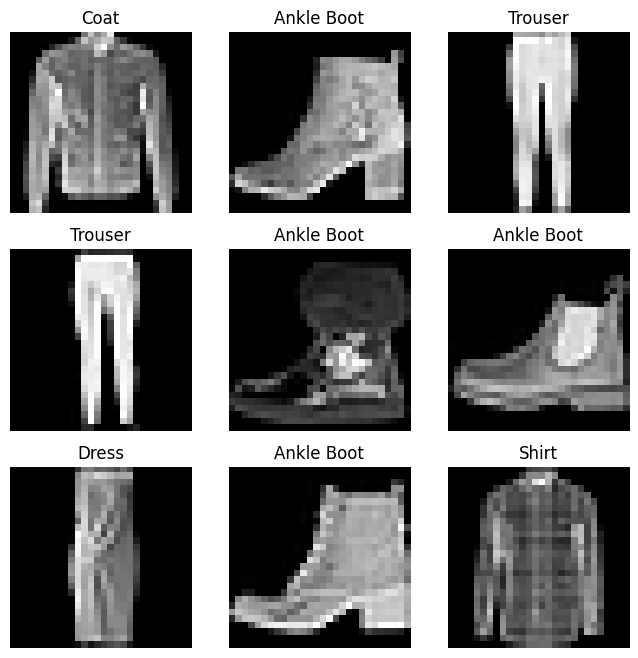

In [3]:
# dataset visualization
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## DataLoader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


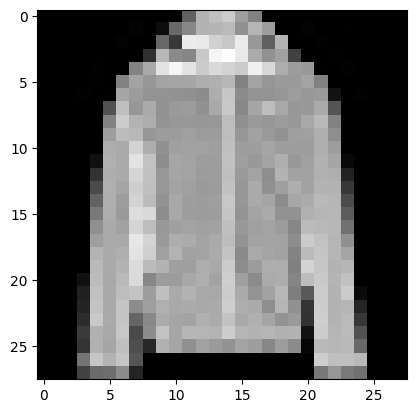

Label: Coat


In [4]:
# dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {labels_map[label.item()]}")

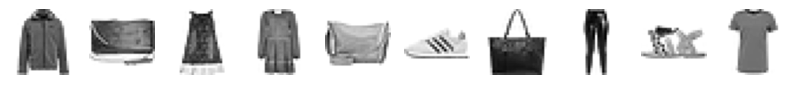

In [5]:
fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axs[i].imshow(train_features[i].squeeze(0), cmap='gray_r')
    axs[i].axis('off')
plt.show()

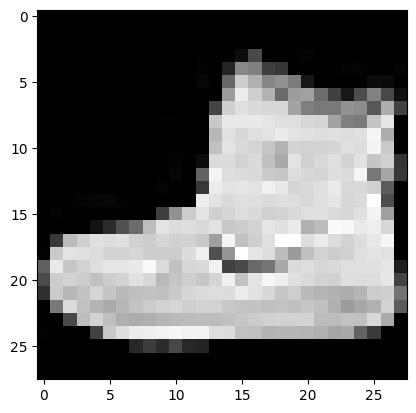

In [6]:
ex_1 = train_dataloader.dataset.data[0].squeeze()
plt.imshow(ex_1, cmap = 'grey')

## Model 생성, 학습, 평가

In [7]:
from torch import nn

linear = nn.Linear(28*28, 10, bias = True).to(device)
softmax = nn.Softmax().to(device)
model = nn.Sequential(linear, softmax).to(device)
model

Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): Softmax(dim=None)
)

In [8]:
from torch import optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [9]:
def train(epoch):
    model.train()
    correct = 0
    
    for data, targets in train_dataloader:
        data = data.to(device).reshape(-1, 28*28)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        # predicted = torch.argmax(outputs.data, 1)
            
        correct += predicted.eq(targets.data.view_as(predicted)).sum()
            
    data_num = len(train_dataloader.dataset)
    print("Acurracy in epoch {} : {}/{} ({:.0f}%)".format(epoch, correct, data_num, 100*correct/data_num))  

In [10]:
def train_repeat(epoch):
    model.train()
    cnt=0
    for cnt in range(epoch):
        correct = 0
        for data, targets in train_dataloader:
            data = data.to(device).reshape(-1, 28*28)
            targets = targets.to(device)
        
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
        
            _, predicted = torch.max(outputs.data, 1)
            # predicted = torch.argmax(outputs.data, 1)
            
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
        data_num = len(train_dataloader.dataset)
        print("Acurracy in epoch {} : {}/{} ({:.0f}%)".format(cnt, correct, data_num, 100*correct/data_num))
        cnt += 1

In [11]:
for epoch in range(5):
    train(epoch)

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Acurracy in epoch 0 : 47428/60000 (79%)
Acurracy in epoch 1 : 50289/60000 (84%)
Acurracy in epoch 2 : 50600/60000 (84%)
Acurracy in epoch 3 : 50862/60000 (85%)
Acurracy in epoch 4 : 51008/60000 (85%)


In [12]:
train_repeat(5)

Acurracy in epoch 0 : 51301/60000 (86%)
Acurracy in epoch 1 : 51378/60000 (86%)
Acurracy in epoch 2 : 51378/60000 (86%)
Acurracy in epoch 3 : 51413/60000 (86%)
Acurracy in epoch 4 : 51534/60000 (86%)


In [13]:
import numpy as np
label = np.unique(training_data.targets, return_counts=True)
label

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [14]:
def test():
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for data, targets in test_dataloader:
            data = data.to(device).view(-1, 28*28)
            targets = targets.to(device)
            
            outputs = model(data)
            
            # _, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs.data, 1)
            
            correct += predicted.eq(targets.data.view_as(predicted)).sum()
            
        data_num = len(test_dataloader.dataset)
        print("Acuraccy in test : {}/{} ({:.0f}%)".format(correct, data_num, 100*correct/data_num))    

In [15]:
test()

Acuraccy in test : 8398/10000 (84%)


predict is	: T-Shirt
answer is	: T-Shirt


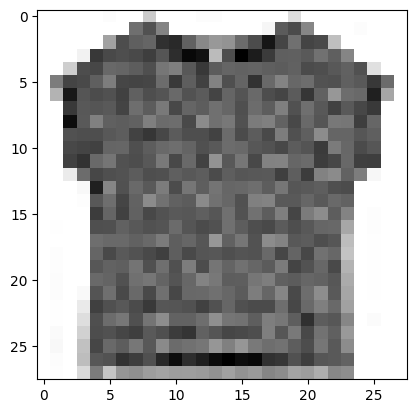

In [17]:
import random as r
index = r.randint(0, len(test_data))

model.eval()

data, target = test_dataloader.dataset[index]
data = data.to(device).reshape(28*28)
output = model(data)
predicted = torch.argmax(output.data, 0)
print("predict is\t:", labels_map[predicted.item()])

data_show = data.cpu().numpy()
plt.imshow(data_show.reshape(28, 28), cmap = 'gray_r')
print("answer is\t:", labels_map[target])